# Проничкин Юрий ДЗ по NLP

## Загрузки, Импорты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip 'drive/My Drive/lenta-ru-ozon-2020.zip'
!pip install pymorphy2
!pip install fasttext


Archive:  drive/My Drive/lenta-ru-ozon-2020.zip
  inflating: lenta-ru-test.csv       
  inflating: lenta-ru-train.csv      
  inflating: sample_submission.csv   
     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 8.2MB 4.0MB/s 
     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3020325 sha256=3e7b9d9f50a71ab3064dbbe549f7f215862e7aee18495cd7307ae8bbdab0206f
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import nltk
import re
import fasttext
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from multiprocessing import Pool
from tqdm import tqdm
from gensim.models import word2vec
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Предобработка

In [4]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")
regex_year = re.compile('[0-9]{4}')
regex_number = re.compile('[0-9]')

def find_year(text, regex=regex_year):
    try:
        if regex_year.search(text) is None:
            return ''
        else:
            return ' 0000'
    except:
        return ''

def find_number(text, regex=regex_number):
    try:
        if regex_number.search(text) is None:
            return ''
        else:
            return ' 0'
    except:
        return ''

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=2048 * 8)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

mystopwords = stopwords.words('russian')

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 2]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas)) +\
               find_year(text) +\
               find_number(text)

def space_tokenaizer(text):
    return text.split(' ')

In [5]:
def create_tokens_lemmas_from_df(df, text_or_title):
    with Pool(2) as p:
        lemmas = list(tqdm(p.imap(clean_text, df[text_or_title]),
                        leave=True,
                        position=0,
                        total=len(df)
                        )
        )
    df[text_or_title + '_lemmas'] = lemmas
    with Pool(2) as p:
        tokens = list(tqdm(p.imap(space_tokenaizer, df[text_or_title + '_lemmas']),
                        leave=True,
                        position=0,
                        total=len(df)
                        )
        )
    df[text_or_title + '_tokens'] = tokens
    return df

In [6]:
df = pd.read_csv('lenta-ru-train.csv')

In [ ]:
df = create_tokens_lemmas_from_df(df, 'title')

 95%|█████████▌| 196888/206637 [01:30<00:04, 2268.12it/s]

In [8]:
df = create_tokens_lemmas_from_df(df, 'text')

100%|██████████| 206637/206637 [00:42<00:00, 4852.78it/s]


## Word2Vec

Сначала попробуем классифицировать по заголовкам

In [9]:
w2v = word2vec.Word2Vec(df['title_tokens'],
                        workers=4,
                        size=300,
                        min_count=10,
                        window=5,
                        sample=1e-3)

In [10]:
X_train,  X_test, y_train, y_test = train_test_split(
     df['title_tokens'],
     df['topic_label']
     )

In [11]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [12]:
w2v = dict(zip(w2v.wv.index2word, w2v.wv.syn0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [13]:
rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=100))])

In [14]:
rfc_w2v.fit(X_train, y_train)
pred = rfc_w2v.predict(X_test)

Precision:   0.80
Recall:   0.71
F1-measure:   0.71
Accuracy:   0.87
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     15880
           1       0.94      0.93      0.94     12963
           2       0.86      0.83      0.84     10580
           3       0.85      0.86      0.86     10757
           4       0.52      0.02      0.03      1480

    accuracy                           0.87     51660
   macro avg       0.80      0.71      0.71     51660
weighted avg       0.86      0.87      0.86     51660



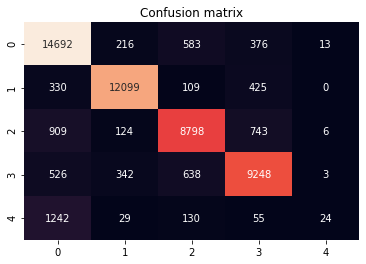

In [15]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Теперь по текстам

In [16]:
w2v = word2vec.Word2Vec(df['text_tokens'],
                        workers=4,
                        size=300,
                        min_count=10,
                        window=5,
                        sample=1e-3)

X_train,  X_test, y_train, y_test = train_test_split(
     df['text_tokens'],
     df['topic_label']
     )

w2v = dict(zip(w2v.wv.index2word, w2v.wv.syn0))

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=100))])

rfc_w2v.fit(X_train, y_train)
pred = rfc_w2v.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  del sys.path[0]


Precision:   0.95
Recall:   0.79
F1-measure:   0.80
Accuracy:   0.95
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     15996
           1       0.99      0.98      0.99     12926
           2       0.96      0.95      0.95     10546
           3       0.96      0.97      0.96     10677
           4       0.93      0.08      0.15      1515

    accuracy                           0.95     51660
   macro avg       0.95      0.79      0.80     51660
weighted avg       0.95      0.95      0.94     51660



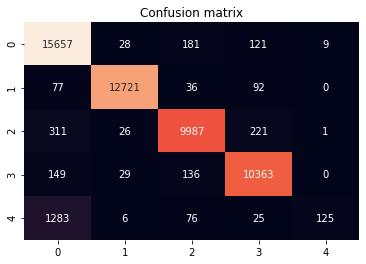

In [17]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [18]:
del w2v

## Fast text

По заголовкам

In [19]:
X_train,  X_test, y_train, y_test = train_test_split(
     df['title_tokens'],
     df['topic_label']
     )

In [20]:
X_train = X_train.reset_index()['title_tokens']
X_test = X_test.reset_index()['title_tokens']
y_train = y_train.reset_index()['topic_label']
y_test = y_test.reset_index()['topic_label']

In [21]:
with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + str(y_train[i]) + ' '+ ' '.join(X_train[i]) + '\n')
    

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + str(y_test[i]) + ' ' + ' '.join(X_test[i]) + '\n')

In [22]:
classifier = fasttext.train_supervised('data.train.txt')#, 'model')
result = classifier.test('test.txt')
print('P@1:', result[1])#.precision)
print('R@1:', result[2])#.recall)
print('Number of examples:', result[0])#.nexamples)

P@1: 0.9275261324041811
R@1: 0.9275261324041811
Number of examples: 51660


In [23]:
pred = classifier.predict([' '.join(x) for x in X_test])[0]
pred = [label[0].split("_")[-1] for label in pred]

In [24]:
pred = np.array(pred).astype('int')

Precision:   0.87
Recall:   0.82
F1-measure:   0.84
Accuracy:   0.93
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     15812
           1       0.98      0.98      0.98     12986
           2       0.92      0.91      0.91     10485
           3       0.94      0.94      0.94     10896
           4       0.62      0.34      0.44      1481

    accuracy                           0.93     51660
   macro avg       0.87      0.82      0.84     51660
weighted avg       0.92      0.93      0.92     51660



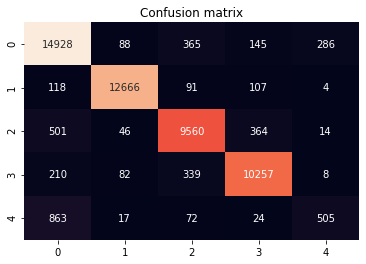

In [25]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))#[i[0] for i in pred]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

По тексту

In [26]:
X_train,  X_test, y_train, y_test = train_test_split(
     df['text_tokens'],
     df['topic_label']
     )

X_train = X_train.reset_index()['text_tokens']
X_test = X_test.reset_index()['text_tokens']
y_train = y_train.reset_index()['topic_label']
y_test = y_test.reset_index()['topic_label']

with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + str(y_train[i]) + ' '+ ' '.join(X_train[i]) + '\n')
    

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + str(y_test[i]) + ' ' + ' '.join(X_test[i]) + '\n')

classifier = fasttext.train_supervised('data.train.txt')#, 'model')
result = classifier.test('test.txt')
print('P@1:', result[1])#.precision)
print('R@1:', result[2])#.recall)
print('Number of examples:', result[0])#.nexamples)

P@1: 0.9645180023228803
R@1: 0.9645180023228803
Number of examples: 51660


Precision:   0.93
Recall:   0.89
F1-measure:   0.91
Accuracy:   0.96
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     15938
           1       0.99      0.99      0.99     12879
           2       0.97      0.97      0.97     10507
           3       0.98      0.98      0.98     10819
           4       0.76      0.55      0.64      1517

    accuracy                           0.96     51660
   macro avg       0.93      0.89      0.91     51660
weighted avg       0.96      0.96      0.96     51660



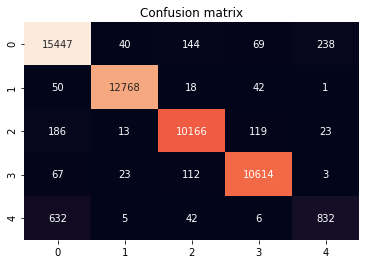

In [27]:
pred = classifier.predict([' '.join(x) for x in X_test])[0]
pred = [label[0].split("_")[-1] for label in pred]
pred = np.array(pred).astype('int')

print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))#[i[0] for i in pred]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [28]:
test_df = pd.read_csv('lenta-ru-test.csv')
test_df = create_tokens_lemmas_from_df(test_df, 'text')

100%|██████████| 51660/51660 [00:10<00:00, 4876.44it/s]


In [29]:
X_train = df.reset_index()['text_tokens']
y_train = df.reset_index()['topic_label']
X_test = test_df.reset_index()['text_tokens']

In [32]:
with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + str(y_train[i]) + ' '+ ' '.join(X_train[i]) + '\n')

In [33]:
classifier = fasttext.train_supervised('data.train.txt')#, 'model')

In [34]:
pred = classifier.predict([' '.join(x) for x in X_test])[0]
pred = [label[0].split("_")[-1] for label in pred]
pred = np.array(pred).astype('int')

In [37]:
np.unique(pred, return_counts=True)

(array([0, 1, 2, 3, 4]), array([16267, 12731, 10770, 10777,  1115]))

In [39]:
test_df['category'] = pred

In [42]:
test_df['id'] = test_df.index

In [43]:
test_df[['id','category']].to_csv('dummy_submission.csv', index=False)

Fasttext сработал на > 0.965

## CNN

Делал только на тексте т.к. в больштнстве заголовков очень мало слов.

In [ ]:
stoi_w2v = dict(zip(w2v.wv.index2word, range(len(w2v.wv.index2word))))

In [ ]:
w2v.wv.vectors

array([[ 0.02096329,  0.16996187, -0.5894184 , ...,  0.85068995,
         0.1377514 ,  0.705117  ],
       [-0.6042455 , -0.22926088,  0.8179877 , ..., -0.49568132,
         0.21253946, -0.07968085],
       [ 0.5221814 ,  0.18414654,  0.328433  , ..., -0.24466984,
        -0.05934364, -0.30147347],
       ...,
       [ 0.05584907,  0.02681151, -0.01490844, ...,  0.01626461,
        -0.02701531,  0.04924833],
       [ 0.02110326,  0.05078917,  0.05530451, ...,  0.04909229,
         0.05408468,  0.0950155 ],
       [ 0.06567957,  0.05017142, -0.01414729, ...,  0.02174419,
        -0.03813747,  0.09408696]], dtype=float32)

In [ ]:
import torch
from torchtext import data

In [ ]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, text_or_title='title', **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.topic_label if not is_test else None
            text = row[text_or_title + '_tokens']
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
train_df, valid_df = train_test_split(df)

In [ ]:
TEXT = data.Field()
LABEL = data.LabelField(dtype = torch.long)

fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df, text_or_title='text')

In [ ]:
print(vars(train_ds[15]))

{'text': ['федеральный', 'антимонопольный', 'служба', 'сей', 'пора', 'поступить', 'уведомление', 'намерение', 'приобрести', 'госпакет', 'акция', 'лукойл', 'передавать', 'риа', 'новость', 'сообщить', 'информагентство', 'пресс', 'служба', 'фас', 'антимонопольный', 'законодательство', 'требовать', 'подобный', 'уведомление', 'речь', 'идти', 'покупка', 'пакет', 'менее', 'процент', 'акция', 'подача', 'уведомление', 'прописать', 'условие', 'аукцион', 'это', 'условие', 'должный', 'выполнить', 'подчеркнуть', 'пресс', 'служба', 'перечень', 'требование', 'участие', 'аукцион', 'продажа', 'госпакет', 'лукойл', 'говориться', 'обязательный', 'оформление', 'документ', 'подтверждать', 'уведомление', 'антимонопольный', 'орган', 'намерение', 'приобрести', 'пакет', 'акция', 'данные', 'газета', 'ведомость', 'заявка', 'участие', 'аукцион', 'собираться', 'подать', 'промсвязьбанк', 'инвестиционный', 'финансовый', 'дом', 'капиталъ', 'американский', 'компания', 'conocophillips', 'dabir', 'international', 'аукци

In [ ]:
print(vars(val_ds[15]))

{'text': ['ноябрь', 'месяц', 'мировой', 'премьера', 'игровой', 'фильм', 'властелин', 'кольцо', 'британский', 'магазин', 'впервые', 'поступить', 'видео', 'dvd', 'мультипликационный', 'версия', 'знаменитый', 'эпос', 'толкиен', 'полнометражный', 'фильм', '0'], 'label': 3}


In [ ]:
TEXT.build_vocab(train_ds, 
                 max_size=25000)
LABEL.build_vocab(train_ds)

In [ ]:
TEXT.vocab.set_vectors(stoi_w2v, torch.from_numpy(w2v.wv.vectors), 300)
LABEL.vocab.set_vectors(stoi_w2v, torch.from_numpy(w2v.wv.vectors), 300)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = 5
DROPOUT = 0.5

train_iterator, valid_iterator= data.BucketIterator.splits(
    (train_ds, val_ds),
    batch_size=128, 
    sort_key=lambda x: len(x.text)
    )

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class train_test_net:
    def __init__(self, net, optimizer, batch_size, criterion, metric, device):
        self.net = net
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.criterion = criterion
        self.metric = metric
        self.device = device
    
    def train(self, train_loader, num_epochs=10, verbose=True, val_loader=None):
        for epoch in range(num_epochs):
            train_loss = 0.0
            train_acc = 0.0
            if val_loader:
                val_acc = 0.0
            self.net = self.net.train()

            loop = tqdm(enumerate(train_loader),
                        position=0,
                        leave=True,
                        mininterval=2)
            for i, batch in loop:

                text = batch.text.to(self.device)
                labels = batch.label.to(self.device).view(-1)
                logits = self.net(text).squeeze(1)
                loss = self.criterion(logits.float(), labels)
                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()
                if verbose:
                    train_loss += loss.detach().item()
                    train_acc += self.metric(logits.float(), labels)
                    loop.set_description(
                                        'Epoch {}/{} Loss:{} Metric:{}'.format(
                                             epoch + 1,
                                             num_epochs,
                                             loss.detach().item(),
                                             self.metric(logits.float(),
                                                         labels))
                                        )
            num_batches_train = i
            self.net.eval()
            with torch.no_grad():
                if val_loader:
                    for i, batch in enumerate(val_loader):

                        val_text = batch.text.to(self.device)
                        val_labels = batch.label.to(self.device).view(-1)
                        val_logits = self.net(val_text).squeeze(1)
                        val_acc += self.metric(val_logits.float(), 
                                            val_labels)
                    num_val_batches = i

            if verbose:
                if val_loader:
                    print("Epoch: %d | Loss: %.4f | "
                          %(epoch + 1, train_loss / (num_batches_train + 1)) + \
                          "Train Accuracy: %.2f | Validation accuracy %.2f" \
                          %(train_acc / (num_batches_train + 1),
                            val_acc / (num_val_batches + 1))
                          )
                else:
                    print("Epoch: %d | Loss: %.4f | "
                          %(epoch + 1, train_loss / (num_batches_train + 1)) + \
                          "Train Accuracy: %.2f" \
                          %(train_acc / (num_batches_train + 1))
                          )

In [ ]:
def get_accuracy(predict, target):
    corrects = (torch.argmax(predict, dim=1) == target)
    accuracy = 100.0 * corrects.sum() / len(target)
    return accuracy.item()

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [sent len, batch size]
        x = x.permute(1, 0)
                
        #x = [batch size, sent len]
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

In [ ]:
net = CNN(INPUT_DIM, 300, 75, [3, 7, 9], OUTPUT_DIM, DROPOUT)

device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0008)

train_test_model = train_test_net(
    net,
    optimizer,
    128,
    criterion,
    get_accuracy,
    device)

In [ ]:
train_test_model.train(train_iterator, num_epochs=5, val_loader=valid_iterator)

Epoch 1/5 Loss:0.22923080623149872 Metric:89.84375: : 1211it [03:15,  6.19it/s]
0it [00:00, ?it/s]

Epoch: 1 | Loss: 0.3401 | Train Accuracy: 88.84 | Validation accuracy 95.20


Epoch 2/5 Loss:0.1549784541130066 Metric:93.75: : 1211it [03:14,  6.22it/s]
0it [00:00, ?it/s]

Epoch: 2 | Loss: 0.1720 | Train Accuracy: 94.51 | Validation accuracy 95.61


Epoch 3/5 Loss:0.05774443596601486 Metric:96.90721130371094: : 1211it [03:14,  6.22it/s]
0it [00:00, ?it/s]

Epoch: 3 | Loss: 0.1251 | Train Accuracy: 95.90 | Validation accuracy 95.91


Epoch 4/5 Loss:0.1264113038778305 Metric:93.75: : 1211it [03:14,  6.22it/s]
0it [00:00, ?it/s]

Epoch: 4 | Loss: 0.0906 | Train Accuracy: 96.98 | Validation accuracy 96.08


Epoch 5/5 Loss:0.024032587185502052 Metric:98.96907043457031: : 1211it [03:15,  6.19it/s]


Epoch: 5 | Loss: 0.0657 | Train Accuracy: 97.81 | Validation accuracy 96.08
